In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(20, 145, 126)

df = pd.read_csv('2017-03-16_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)
centred_moment_5 = moment(org_values, moment=5, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((126,5))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)
out_array[:,4] = np.divide(centred_moment_5,st_dev*st_dev*st_dev*st_dev*st_dev)

print(st_dev)

print(np.mean(org_values, axis=1))
print(centred_moment_3)

# print(centred_moments.shape)


[14.86060228 13.88279061 13.55486167 12.97926327 12.03575818 12.35744614
 12.08409699 11.44847588 11.13258281 10.93588017 10.6475948  10.41145523
 10.33775967  9.91177456  9.47984573  9.14579002  8.67290465  8.50707206
  7.98967459  7.83100249  7.32841047  7.157407    7.09295425  6.69082207
  6.03927976  6.09031198  5.78968695  5.73430685  5.24595082  5.17354811
  4.69142569  4.77540312  4.59428993  4.50748267  4.14751432  3.84122376
  3.64505144  3.56568367  3.30894243  3.04580039  3.00214923  2.91363604
  2.76196941  2.61905995  2.55563593  2.56941141  2.20966061  2.10558187
  2.08290062  1.93945224  1.80401635  1.77095313  1.69182594  1.6208871
  1.62929433  1.5396347   1.38031699  1.40356688  1.30789908  1.30164319
  1.19644264  1.1721348   1.00826584  1.09602692  1.02083299  1.02590204
  0.9932774   0.93609561  0.89493016  0.88317609  0.84711274  0.83562851
  0.80380346  0.82175118  0.76503268  0.81809229  0.78375698  0.77323994
  0.66098411  0.6684871   0.61351447  0.69021736  0.

Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 5
noise_value = 25
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
noise_arr[0] = 1
noise_arr[1] = 1
noise_arr[2] = 1
noise_arr[3] = 1
noise_arr[4] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 7


Create uniform log prior

In [5]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.000001
prior_arr_upper[0] = 0.1
prior_arr_lower[1] = 1
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_74605/1626152413.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 1000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.3
1     528     0:01.6
2     1008    0:02.8
3     1488    0:04.1
20    7977    0:20.9
40    14259   0:38.0
60    20304   0:54.4
80    26472   1:11.1
100   32844   1:27.9
120   38826   1:43.9
140   45012   2:00.2
160   51390   2:16.9
180   57723   2:33.5
200   64032   2:50.0
220   69885   3:05.4
240   76080   3:21.7
260   82131   3:37.7
280   88239   3:53.7
300   94632   4:10.6
320   101085   4:27.6
340   107496   4:44.4
360   113448   5:00.0
380   119700   5:16.5
400   125985   5:33.1
420   132129   5:49.2
440   138336   6:05.8
460   144759   6:23.8
480   151236   6:41.6
500   157389   6:58.1
520   163614   7:14.3
540   170220   7:31.3
560   176091   7:47.6
580   182511   8:04.5
600   188694   8:21.1
620   194742   8:37.4
640   200760   8:53.3
660   206853   9:09.5
680   213000   9:25.7
700   219195   9:42.8
720   225396  10:00.6
740   231324  10:17.7
760   237093  1

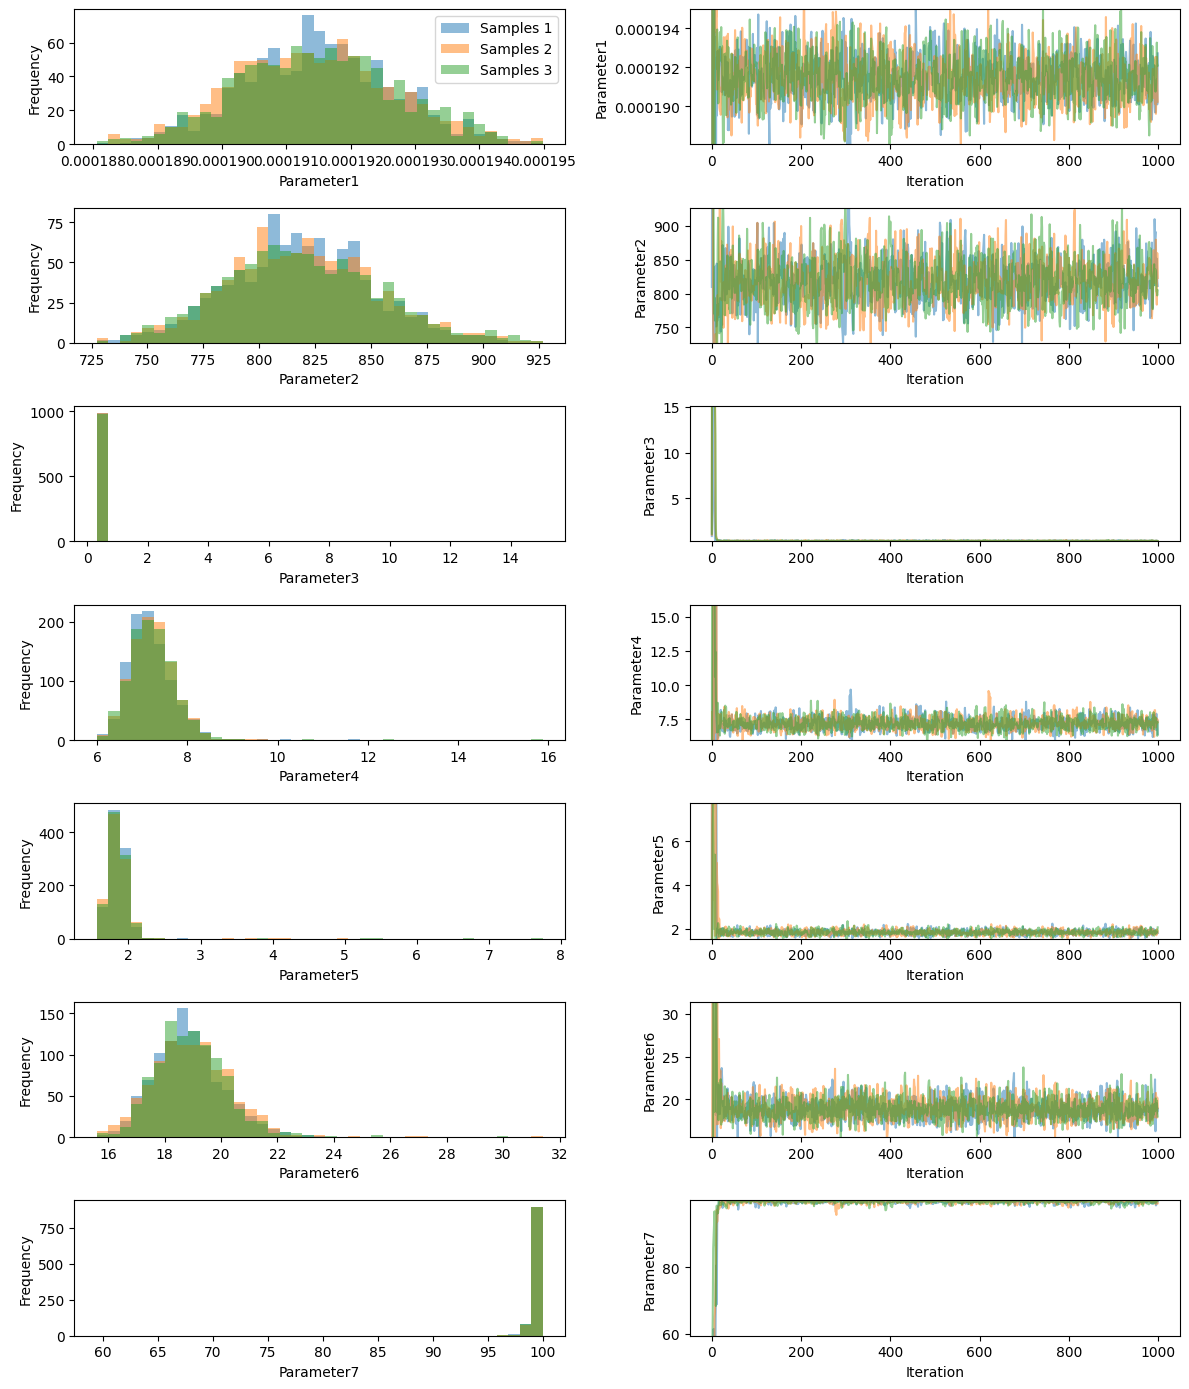

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [8]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 7)
[1.92041247e-04 7.80027892e+02 3.89523188e-01 6.88018980e+00
 1.86766671e+00 1.69055376e+01 9.94026887e+01]
[[1.92041247e-04 7.80027892e+02 3.89523188e-01 ... 1.86766671e+00
  1.69055376e+01 9.94026887e+01]
 [1.92989685e-04 8.00269162e+02 3.88910396e-01 ... 1.81676845e+00
  1.95334194e+01 9.94270534e+01]
 [1.89580162e-04 9.04006172e+02 3.74898309e-01 ... 1.86880896e+00
  1.79521108e+01 9.98875816e+01]
 ...
 [1.91380136e-04 8.51304528e+02 3.96163088e-01 ... 1.86153001e+00
  1.95733533e+01 9.96498912e+01]
 [1.90097023e-04 8.18423368e+02 3.87440004e-01 ... 1.85620932e+00
  1.85274703e+01 9.94403519e+01]
 [1.92712369e-04 8.11211436e+02 3.44183212e-01 ... 1.81172291e+00
  1.89199876e+01 9.96010711e+01]]


In [9]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


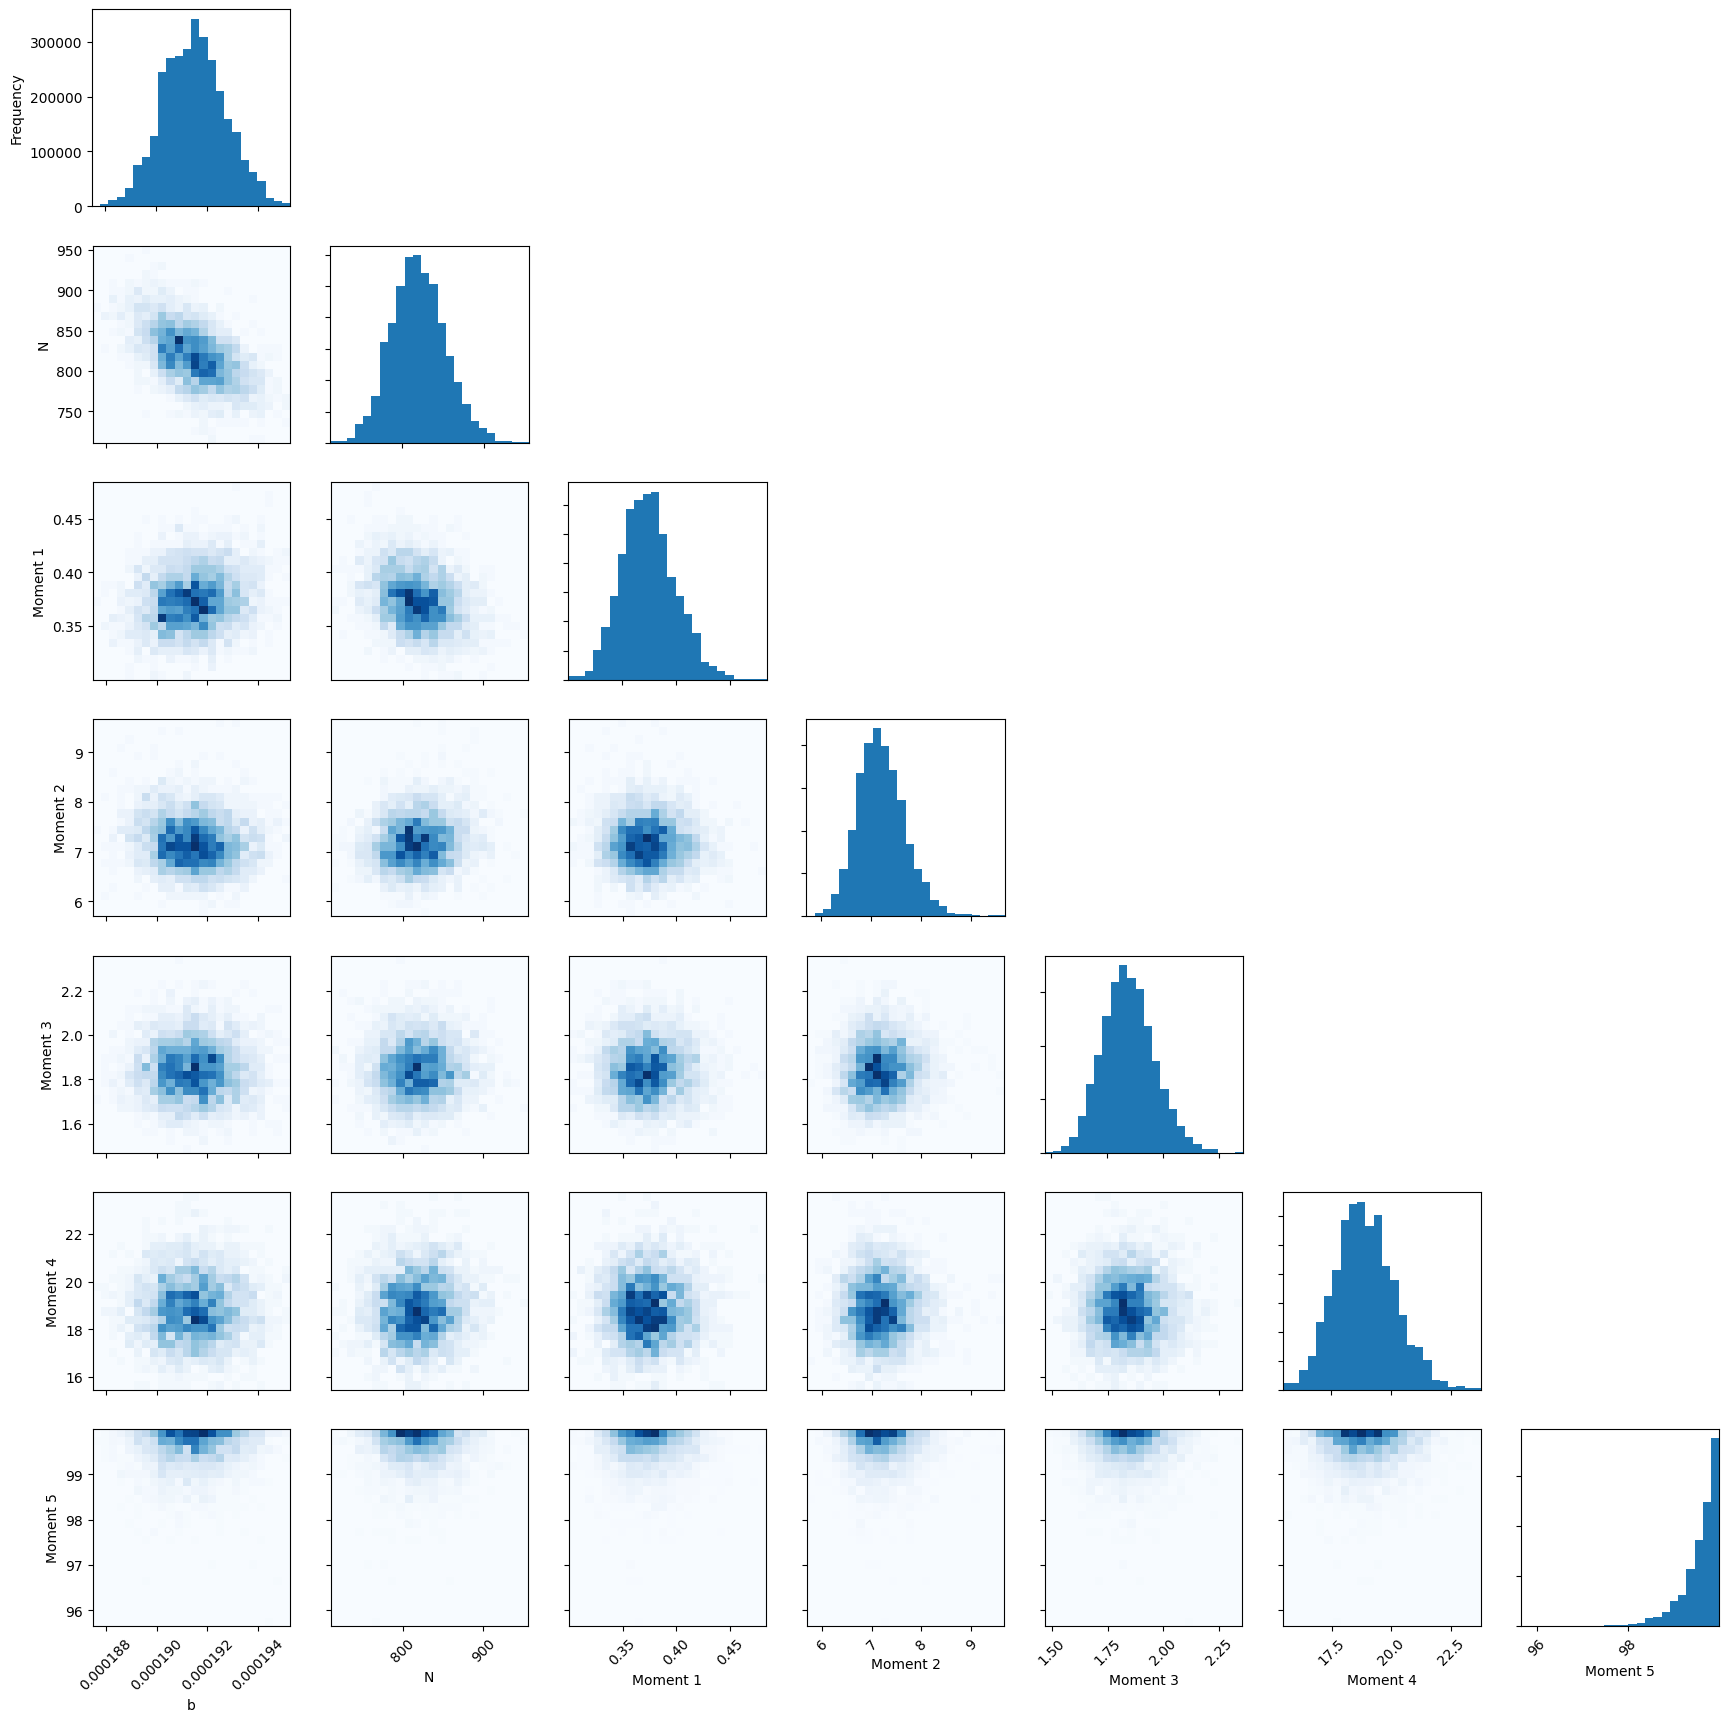

In [10]:


parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"])
plt.show()

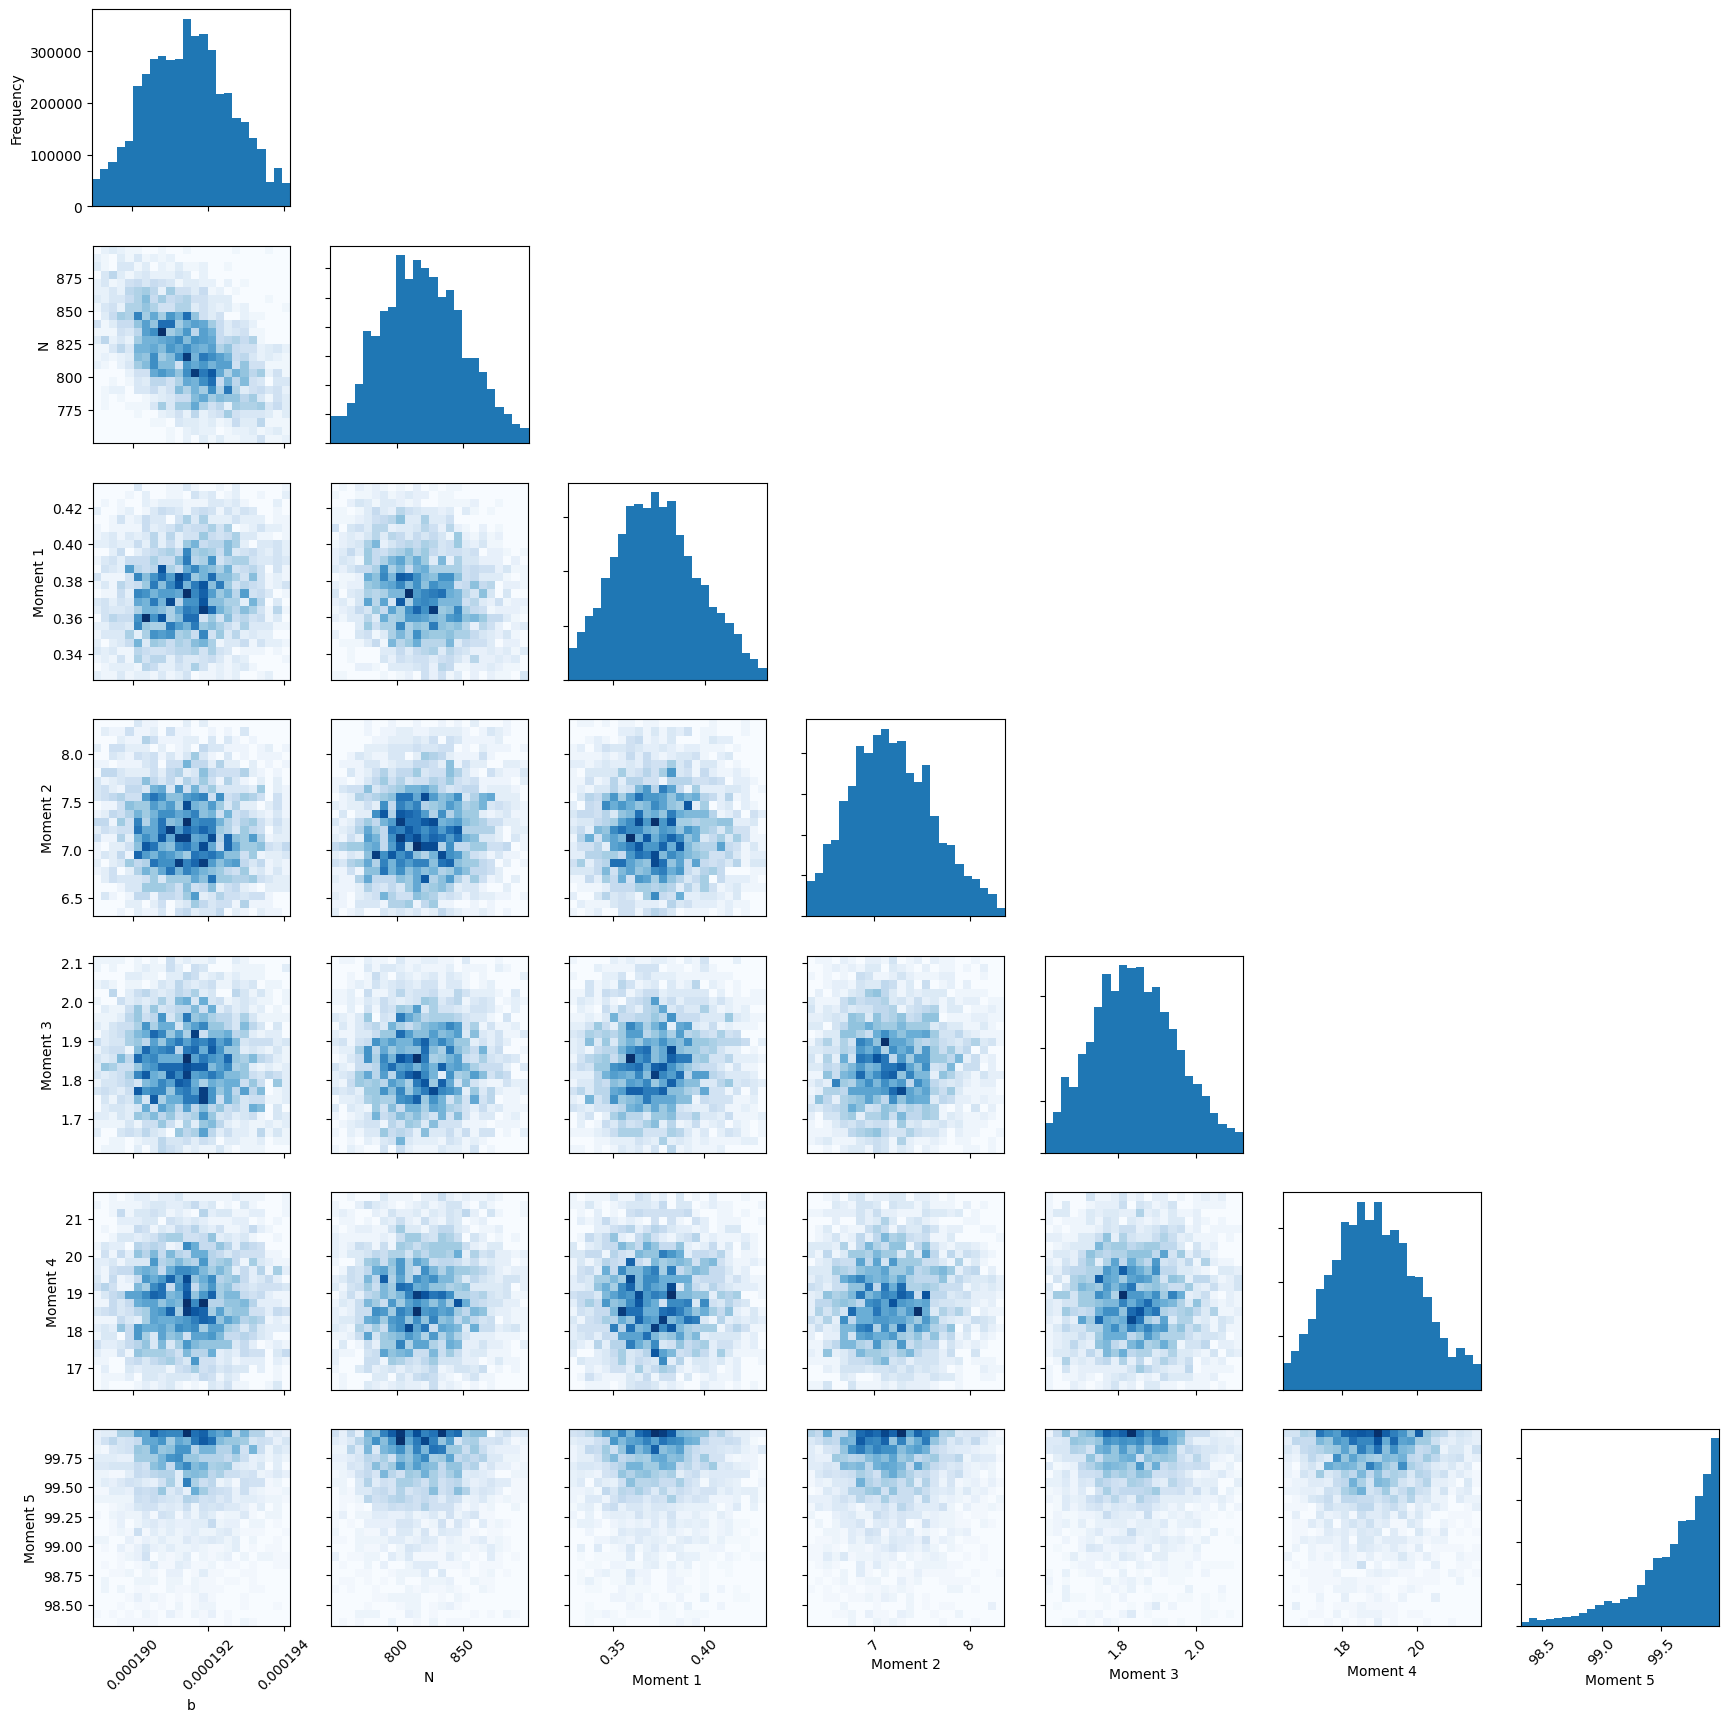

In [11]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"],
                    n_percentiles=97)
                    
plt.show()

[1.92041247e-04 7.80027892e+02 3.89523188e-01 6.88018980e+00
 1.86766671e+00 1.69055376e+01 9.94026887e+01]


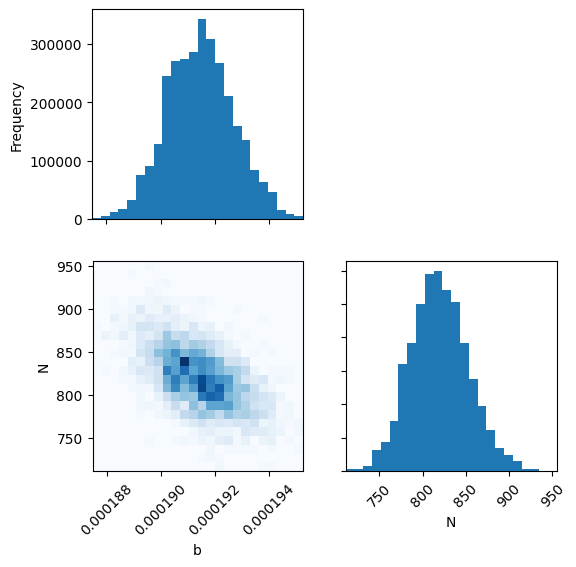

In [12]:
parameter_names = ["b","N"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1]], heatmap=True, 
                    parameter_names=["b","N"])
plt.savefig("Pints_pairwise.png", dpi =300)
plt.show()


In [13]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
--------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
b         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.00    404.18  0.49
N         820.04  31.89   759.13  799.49  818.40  841.20  885.60   1.00    387.00  0.46
Moment 1  0.37    0.02    0.33    0.36    0.37    0.39    0.42     1.00    468.60  0.56
Moment 2  7.21    0.49    6.34    6.88    7.18    7.51    8.25     1.00    468.12  0.56
Moment 3  1.85    0.11    1.63    1.77    1.84    1.92    2.08     1.00    493.84  0.59
Moment 4  18.91   1.24    16.66   18.06   18.85   19.70   21.48    1.00    494.67  0.59
Moment 5  99.57   0.40    98.50   99.42   99.69   99.87   99.99    1.01    284.05  0.34


In [14]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [15]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess    ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  -----  --------------
b         0.000191  1.17e-06  0.000189  0.000191  0.000191  0.000192  0.000194  1       404    0.485
N         820       31.9      759       799       818       841       886       0.999   387    0.465
Moment 1  0.375     0.0245    0.329     0.358     0.374     0.39      0.425     1       469    0.562
Moment 2  7.21      0.487     6.34      6.88      7.18      7.51      8.25      1       468    0.562
Moment 3  1.85      0.114     1.63      1.77      1.84      1.92      2.08      1       494    0.593
Moment 4  18.9      1.24      16.7      18.1      18.9      19.7      21.5      0.999   495    0.594
Moment 5  99.6      0.4       98.5      99.4      99.7      99.9      100       1.01    284    0.341


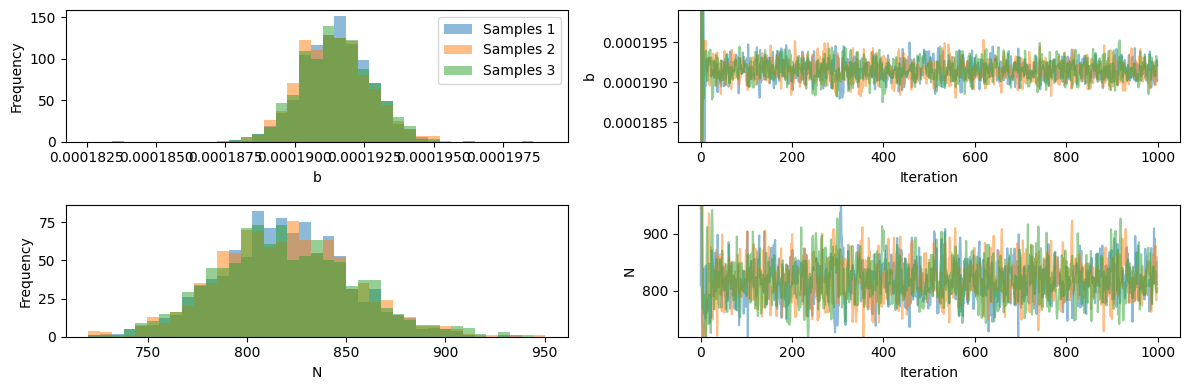

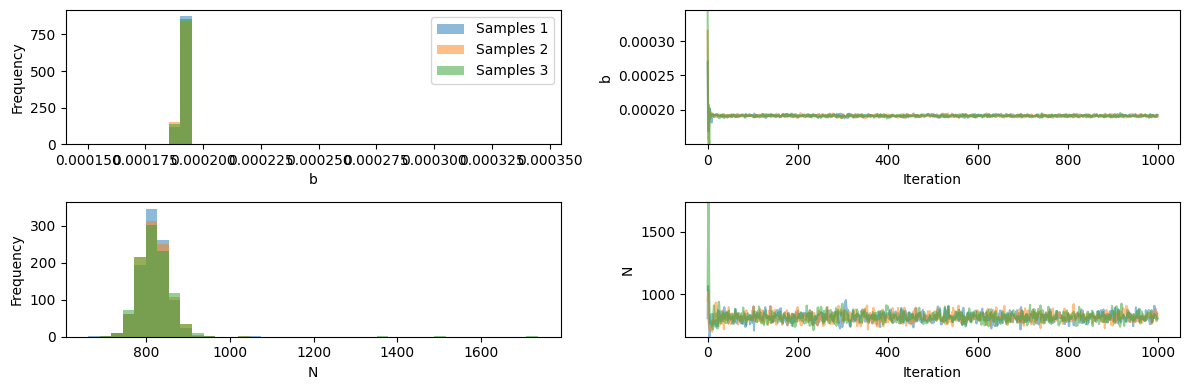

In [16]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()